In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import gym
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
from gym import wrappers
from collections import deque
import random
import numpy as np
import math
import os
%matplotlib inline

from gym import logger as gymlogger
from gym.wrappers import Monitor
from IPython.display import HTML
import progressbar
import glob
import io
import base64
from IPython import display as ipythondisplay

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
#from keras.callbacks import TensorBoard
from keras.optimizers import Adam

Using TensorFlow backend.


Environment

In [8]:
class PheonixEnvironment(gym.Env):
  def __init__(self):
    self.env = gym.make('CartPole-v0')
    self.num_states = self.env.observation_space.shape[0]
    self.num_actions = self.env.action_space.n
    self.deque_list = deque(maxlen=10000)
    self.epsilon = 1
    self.epochs = 1
    self.gamma = 0.95
    self.episodes = 1500
    self.timesteps = 0
    self.min_memory = 500
    self.min_batch_size = 24
    self.min_epsilon = 0.001
    self.alpha = 0.001
    self.reward_threshold = 0
    self.reward_target = 195
    self.epsilon_delta =  (self.epsilon - self.min_epsilon)/200
    self.reward_per_episode = []
    self.epsilon_per_episode = []
    self.avg_rewards = []
    self.steps_per_episode = []

    ## Keras save and load
    ## adopted from Keras training FAQs
    ## Url: https://keras.io/getting_started/faq/#how-can-i-regularly-save-keras-models-during-training
    self.checkpoint_dir = F"/content/gdrive/My Drive/cartpole_ddqn_scenario6"
    if not os.path.exists(self.checkpoint_dir):
        os.makedirs(self.checkpoint_dir)

    self.callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the folder name.
    keras.callbacks.ModelCheckpoint(
        filepath=self.checkpoint_dir + '/ckpt-loss={loss:.2f}', period=100)]
    ###

    self.primary_model = self.make_or_restore_model()
    self.target_model = self.make_or_restore_model()
    
    self.target_model.set_weights(self.primary_model.get_weights())
    

  ## Keras save and load
  ## method adopted from Keras training FAQs
  ## Url: https://keras.io/getting_started/faq/#how-can-i-regularly-save-keras-models-during-training
  def make_or_restore_model(self):
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [self.checkpoint_dir + '/' + name
                   for name in os.listdir(self.checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print('Restoring from', latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print('Creating a new model')
    return self.create_model()

  def reset_all(self):
    return self.env.reset()

  def preprocess(self, state):
    return np.reshape(state,(1, self.num_states))

  def create_model(self):
    model = Sequential()
    model.add(Dense(24, input_dim=self.num_states, activation="relu"))
    model.add(Dense(24, activation="relu"))
    model.add(Dense(self.num_actions, activation="linear"))
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=self.alpha))
    return model

  def choose_action(self, state, t):
    if np.random.uniform(0, 1) < self.epsilon: 
      action = np.random.choice(self.num_actions)
      #print('Random action!', action)
    else: 
      values = self.primary_model.predict(state)
      action = np.argmax(values[0])
      #print('Predicted action!', action)
    return action

  def train(self, sample_batch):
    for old_state, action, reward, next_state, done in sample_batch:
      q_val = self.primary_model.predict(old_state)
      if not done:
        temp_q = self.target_model.predict(next_state)
        q_val[0][action] = reward + (self.gamma * np.amax(temp_q))
      else:
        q_val[0][action] = reward
      self.primary_model.fit(old_state, q_val, epochs=1, verbose=0, callbacks=self.callbacks)

  def train_ddqn(self, sample_batch):
    for old_state, action, reward, next_state, done in sample_batch:
      q_val = self.primary_model.predict(old_state)
      if not done:
        target_action = np.argmax(self.primary_model.predict(next_state)[0])
        q_val[0][action] = reward + (self.gamma * self.target_model.predict(next_state)[0][target_action])
      else:
        q_val[0][action] = reward
      self.primary_model.fit(old_state, q_val, epochs=1, verbose=0, callbacks=self.callbacks)
      #self.primary_model.fit(old_state, q_val, epochs=1, verbose=0)

  def get_epsilon(self, e, last_reward):
    ## Implementation adapted from Reward Based Epsilon Decay
    ## Url: https://aakash94.github.io/Reward-Based-Epsilon-Decay/

    #self.epsilon = max(self.epsilon * 0.995, self.min_epsilon)
    #self.epsilon = 1 / math.log10(e + 0.00001)
    if last_reward > self.reward_threshold:    
      self.epsilon = max(self.epsilon - self.epsilon_delta, self.min_epsilon)
      self.reward_threshold = self.reward_threshold + 1

  def execute(self):
    last_reward = 0
    for episode in range(self.episodes):  
      #print("Starting Episode:", episode)
      old_state = self.reset_all()
      old_state = self.preprocess(old_state)
      total_reward = 0
      t = 0
      done = False     
      while not done:
        
        action = self.choose_action(old_state, episode)
        
        next_state, reward, done, info = self.env.step(action)
        next_state = self.preprocess(next_state)
        self.deque_list.append((old_state, action, reward, next_state, done))
        old_state = next_state
        
        total_reward += reward
        t += 1
        # if t%10 == 0:  
        self.timesteps += 1        
      
      if episode%2 and len(self.deque_list) > self.min_batch_size:
        sample_batch = random.sample(self.deque_list, self.min_batch_size)
        self.train_ddqn(sample_batch)
      if episode%30 == 0:
        self.target_model.set_weights(self.primary_model.get_weights())

      self.reward_per_episode.append(total_reward)
      self.epsilon_per_episode.append(self.epsilon)
      self.steps_per_episode.append(t)
      print("Episode: ",episode,"Completed with epsilon: ",self.epsilon," Total Reward: ", total_reward
            ," Timesteps till now: ", self.timesteps)
      self.get_epsilon(episode, total_reward)
 
  def analysis(self):
    print("Plotting analysis....")
    episodes = list(range(0,self.episodes))
    plt1.plot(episodes, self.reward_per_episode)
    plt1.xlabel('Episodes')
    plt1.ylabel('Rewards')
    plt1.show()

    k=0
    avg_rewards = []
    for i in range(1, int(self.episodes/100) + 1):
      avg_rewards.append(np.average(self.reward_per_episode[k:(i*100)-1]))
      k += 100

    episodes2 = [x*100 for x in range(1,int(self.episodes/100)+1)]
    print(episodes2)
    print(avg_rewards)
    #plt2.bar(episodes2, avg_rewards, width=8)
    plt2.plot(episodes2, avg_rewards)
    plt2.xlabel('Episodes')
    plt2.ylabel('Avg rewards')
    plt2.show()

    plt3.plot(episodes, env.epsilon_per_episode)
    plt2.xlabel('Episodes')
    plt2.ylabel('Epsilon')
    plt3.show()

  def test(self):
    old_state = self.reset_all()
    old_state = self.preprocess(old_state)
    total_reward = 0
    done = False
    t = 0
    while not done:
      #action = self.choose_action(old_state, episode)
      values = self.primary_model.predict(old_state)
      action = np.argmax(values[0])
      print("Action: ", action)
      next_state, reward, done, info = self.env.step(action)
      old_state = self.preprocess(next_state)
      
      total_reward += reward

      screen = self.env.render('rgb_array')
      plt.imshow(screen)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      t += 1
    
    print("Testing done! reward= ", total_reward)
  

In [9]:
env = PheonixEnvironment()

Restoring from /content/gdrive/My Drive/cartpole_ddqn_scenario6/ckpt-loss=0.02
Restoring from /content/gdrive/My Drive/cartpole_ddqn_scenario6/ckpt-loss=0.02


Episode:  0 Completed with epsilon:  1  Total Reward:  13.0  Timesteps till now:  13
Episode:  1 Completed with epsilon:  0.995005  Total Reward:  18.0  Timesteps till now:  31
Episode:  2 Completed with epsilon:  0.9900100000000001  Total Reward:  15.0  Timesteps till now:  46
Episode:  3 Completed with epsilon:  0.9850150000000001  Total Reward:  13.0  Timesteps till now:  59
Episode:  4 Completed with epsilon:  0.9800200000000001  Total Reward:  17.0  Timesteps till now:  76
Episode:  5 Completed with epsilon:  0.9750250000000001  Total Reward:  48.0  Timesteps till now:  124
Episode:  6 Completed with epsilon:  0.9700300000000002  Total Reward:  14.0  Timesteps till now:  138
Episode:  7 Completed with epsilon:  0.9650350000000002  Total Reward:  22.0  Timesteps till now:  160
Episode:  8 Completed with epsilon:  0.9600400000000002  Total Reward:  9.0  Timesteps till now:  169
Episode:  9 Completed with epsilon:  0.9550450000000003  Total Reward:  16.0  Timesteps till now:  185
Epi

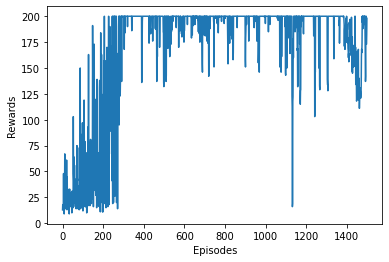

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
[32.03030303030303, 52.58585858585859, 124.51515151515152, 197.66666666666666, 195.13131313131314, 192.26262626262627, 195.66666666666666, 196.23232323232324, 196.11111111111111, 195.77777777777777, 196.67676767676767, 184.0, 194.6161616161616, 193.8080808080808, 165.17171717171718]


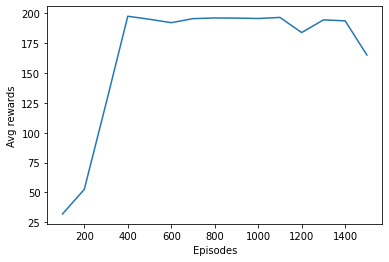

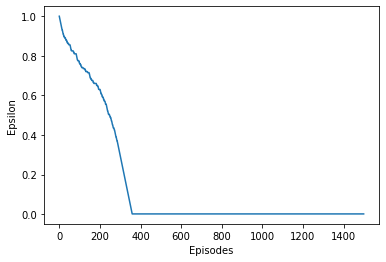

In [10]:
env.execute()
env.analysis()